# Using Keras Functional API
-----------------------------

In [ ]:
import tensorflow as tf
from tensorflow import keras



### 1 - Create a Functional model

The deep learning model is usually a directed acyclic graph (DAG). The `Functional API` is a way to build a graph of layers and to create more flexible models than the `tf.keras.Sequential` API.


To build a model, multiple layers are stacked. A layer instance is callable (on a tensor) and returns a tensor.

Let's go and make out a functional model for recognizing [MNIST data](http://yann.lecun.com/exdb/mnist/).

#### Load MNIST dataset


In [ ]:
mnist = tf.keras.datasets.mnist
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step



#### Normalize the grayscale image

In [ ]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    image_data_min = image_data.min()
    image_data_max = image_data.max()
    return a + ((image_data - image_data_min)*(b-a))/(image_data_max - image_data_min)

train_mnist_features = normalize_grayscale(X_mnist_train)
test_mnist_features = normalize_grayscale(X_mnist_test)


#### Build the model

We add 1 flatten layer and 2 dense layers in order to do a classification task between 10 classes.

The goal is to predict the digit written on each image (from 0 to 9).

In [ ]:
# Input() is used to instantiate a Keras tensor.
inputs = tf.keras.Input(shape=(28,28))

# Flatten the images of size (28,28) to have an array of 784 pixels
flatten_layer = keras.layers.Flatten()

# And we add a new node in the graph of layers 
# by calling a flatten layer on the inputs object :
flatten_output = flatten_layer(inputs)

#Then, we create a new layer instance :
dense_layer = tf.keras.layers.Dense(50, activation='relu')
# Add a new node
dense_output = dense_layer(flatten_output)

predictions = tf.keras.layers.Dense(10, activation='softmax')(dense_output)

# The model instance formalizes the computational graph 
# on how the data flows from input(s) to output(s).
model = keras.Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


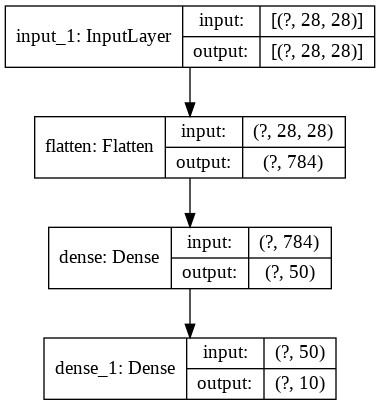

In [ ]:
keras.utils.plot_model(model, 'funct_model_mnist.png', show_shapes=True)


#### Compile and Fit the model
Such a model can be trained and evaluated by the same compile, fit, evaluate and predict methods used in the Keras Sequential model. 

In [ ]:
# Compile
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(train_mnist_features, y_mnist_train, validation_data=(test_mnist_features, y_mnist_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7701 - accuracy: 0.8080 - val_loss: 0.4042 - val_accuracy: 0.8920
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3809 - accuracy: 0.8951 - val_loss: 0.3296 - val_accuracy: 0.9077
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3305 - accuracy: 0.9066 - val_loss: 0.2981 - val_accuracy: 0.9152
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3043 - accuracy: 0.9133 - val_loss: 0.2811 - val_accuracy: 0.9204
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2852 - accuracy: 0.9194 - val_loss: 0.2639 - val_accuracy: 0.9252
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2691 - accuracy: 0.9241 - val_loss: 0.2549 - val_accuracy: 0.9288
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2554 - accuracy: 0.9278 - val_loss: 0.2416 - val_accuracy:

### 2 - Use callable models like layers

If we’re facing a sequence problem, creating a model will become very easy with the Functional API. For example, instead of processing one image, we want to process a video which is composed of many images. We could turn an image classification model into a video classification in just one line using the TimeDistributed layer wrapper. This wrapper applies our previous model to every temporal slice of the input sequence, means, to each image of our video.



In [ ]:
from keras.layers import TimeDistributed

# Input tensor for sequences of 50 timesteps,
# each containing a 28x28 dimensional matrix.
input_sequences = tf.keras.Input(shape=(10, 28, 28))

# We will applythe previous model to each sequence so one for each timestep.
# The MNIST model returns a vector with 10probabilities (one for each digit).
# The TimeDistributed output will be a sequence of 50 vectors of size 10.
processed_sequences = tf.keras.layers.TimeDistributed(model)(input_sequences)


### 3 - Create a model with multiple inputs and outputs

Let’s go with an example. We’re going to build a system for predicting the price of a specific house and the elapsed time before the sales with multiple inputs and outputs.

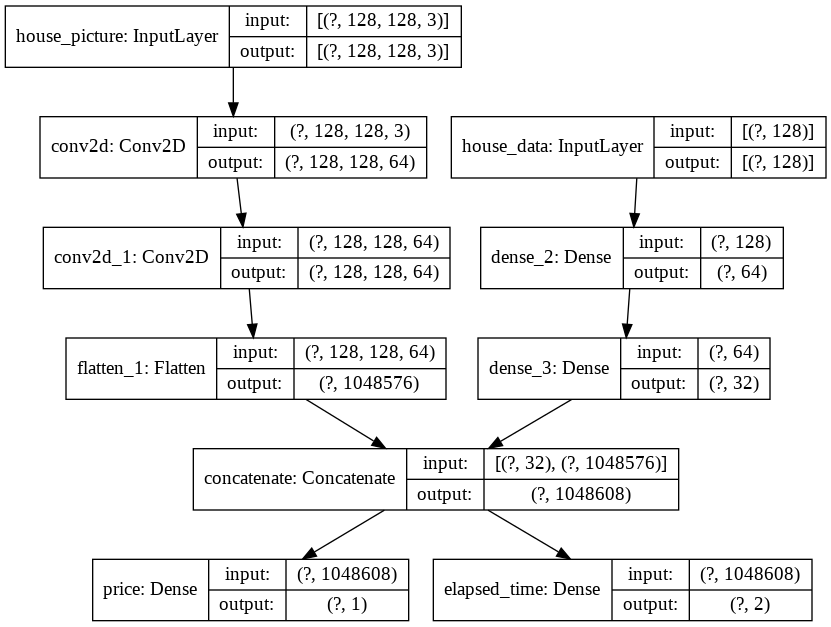

In [ ]:
house_data_inputs = tf.keras.Input(shape=(128,), name='house_data')
x = tf.keras.layers.Dense(64, activation='relu')(house_data_inputs)
block_1_output = tf.keras.layers.Dense(32, activation='relu')(x)
 
house_picture_inputs = tf.keras.Input(shape=(128,128,3), name='house_picture')
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(house_picture_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = tf.keras.layers.Flatten()(x)
 
# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([block_1_output, block_2_output])

# Stick a logistic regression for price prediction on top of the features
price_pred = tf.keras.layers.Dense(1, name='price', activation='relu')(x)
# Stick a time classifier on top of the features
time_elapsed_pred = tf.keras.layers.Dense(2, name='elapsed_time', activation='softmax')(x)

 
model = keras.Model([house_data_inputs, house_picture_inputs], 
                    [price_pred, time_elapsed_pred], 
                    name='toy_house_pred')

keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### 4 - Share Layers

Let’s consider two different sequences of text.

We will apply the same embedding layer to these two sequences that feature similar vocabulary.

In [ ]:
# Variable-length sequence of integers
text_input_a = tf.keras.Input(shape=(None,), dtype='int32')

# Variable-length sequence of integers
text_input_b = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = tf.keras.layers.Embedding(1000, 128)

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

### 5 - Extract and Reuse nodes in the graph of layers 
Take a look at how to read the shared layer’s output and output_shape

In [ ]:
# Create a sequence of integers
int_input_a = tf.keras.Input(shape=(None,), dtype='int32')

# Create a sequence of integers
int_input_b = tf.keras.Input(shape=(None,), dtype='int32')

# Create an embedding layer for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = tf.keras.layers.Embedding(1000, 128)

# Encode both inputs with the same layer
encoded_input_a = shared_embedding(int_input_a)
encoded_input_b = shared_embedding(int_input_b)

In [ ]:
# Get Node 0 Output of shared embedding layer
print(shared_embedding.get_output_at(0))
# Get Node 1 Output of shared embedding layer
print(shared_embedding.get_output_at(1))

Tensor("embedding_1/embedding_lookup/Identity_1:0", shape=(None, None, 128), dtype=float32)
Tensor("embedding_1/embedding_lookup_1/Identity_1:0", shape=(None, None, 128), dtype=float32)


In [ ]:
# Get Node 0 input shape of shared embedding layer
print(shared_embedding.get_input_shape_at(0))
# Get Node 1 input shape of shared embedding layer
print(shared_embedding.get_input_shape_at(1))

(None, None)
(None, None)


In [ ]:
# Get Node 0 output shape of shared embedding layer
print(shared_embedding.get_output_shape_at(0))
# Get Node 1 output shape of shared embedding layer
print(shared_embedding.get_output_shape_at(1))

(None, None, 128)
(None, None, 128)


Let’s go to download the ResNet 50 pre-trained model

In [ ]:
resnet = tf.keras.applications.resnet.ResNet50()
intermediate_layers = [layer.output for layer in resnet.layers]

# Display all the ouput layers
intermediate_layers

[<tf.Tensor 'input_9:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'conv1_pad/Pad_2:0' shape=(None, 230, 230, 3) dtype=float32>,
 <tf.Tensor 'conv1_conv/BiasAdd_2:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'conv1_bn/cond_2/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'conv1_relu/Relu_2:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'pool1_pad/Pad_2:0' shape=(None, 114, 114, 64) dtype=float32>,
 <tf.Tensor 'pool1_pool/MaxPool_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_conv/BiasAdd_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_bn/cond_2/Identity:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_relu/Relu_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_2_conv/BiasAdd_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_2_bn/cond_2/Identity:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_

In [ ]:
intermediate_layers[:10]

[<tf.Tensor 'input_9:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'conv1_pad/Pad_2:0' shape=(None, 230, 230, 3) dtype=float32>,
 <tf.Tensor 'conv1_conv/BiasAdd_2:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'conv1_bn/cond_2/Identity:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'conv1_relu/Relu_2:0' shape=(None, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'pool1_pad/Pad_2:0' shape=(None, 114, 114, 64) dtype=float32>,
 <tf.Tensor 'pool1_pool/MaxPool_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_conv/BiasAdd_2:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_bn/cond_2/Identity:0' shape=(None, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2_block1_1_relu/Relu_2:0' shape=(None, 56, 56, 64) dtype=float32>]

In [ ]:
feature_layers = intermediate_layers[:-2]

In [ ]:
feat_extraction_model = keras.Model(inputs=resnet.input, outputs=feature_layers)